# Schelling model on a network

Todo: Build a version using this code but use popy for network generation: https://agentpy.readthedocs.io/en/latest/agentpy_segregation.html

In [1]:
import popy
from popy.pop_maker import PopMaker
from popy.data_fakers.soep import soep_faker

import random

import agentpy as ap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.rel_same_desired = self.model.p.rel_same_desired
        

    def get_location(self, location_type):
        return [location for location in self.locations if isinstance(location, location_type)][0]
    

    def eval(self, location_type, attribute: str):
        location = self.get_location(location_type=location_type)
        n_same = sum([getattr(self, attribute) == getattr(neighbor, attribute) for neighbor in location.neighbors(self)])
        n = len(location.neighbors(self))
        if n > 0:
            rel_same = n_same / n
            return rel_same
        else:
            return 1
        

    def move(self, location_type):
        old_location = self.get_location(location_type=location_type)
        potential_new_locations = [l for l in self.model.locations if isinstance(l, location_type) and l is not old_location]
        
        if len(potential_new_locations) > 0:
            new_location = random.choice(potential_new_locations)
            # !!!! DER FOLGENDE PROZESS MUSS ÜBERARBEITET UND VEREINFACHT WERDEN !!!!
            # VIELLEICHT EINE Agent.move(old_location, new_location)-Methode einbauen
            old_location.remove_agent(self)
            new_location.add_agent(self)

            
    def eval_and_move(self, location_type, attribute):
        rel_same = self.eval(location_type=location_type, attribute=attribute)
        if rel_same < self.rel_same_desired:
            self.move(location_type=location_type)

In [3]:
class Work(popy.Location):
    def setup(self):
        self.size = self.model.p.location_size

In [4]:
class Model(popy.Model):
    def setup(self):
        df_soep = soep_faker.soep(size=self.p.n_agents)    
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(agents=self.agents, location_classes=[Work])

    
    def get_segregation(self):
        return sum([agent.eval(location_type=Work, attribute="gender") for agent in self.agents]) / len(self.agents)
        
    
    def step(self):
        random_agent = random.choice(self.agents)
        random_agent.eval_and_move(location_type=Work, attribute="gender")


    def end(self):
        self.report('segregation', self.get_segregation())

In [5]:
parameters_multi = {
    "n_agents": 100,
    "steps": 1000,
    'rel_same_desired': ap.Values(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    "location_size": ap.Values(5, 10, 50, 100),    
}
sample = ap.Sample(parameters_multi)

exp = ap.Experiment(Model, sample, iterations=10)
results = exp.run()

Scheduled runs: 440
Completed: 440, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:16.894732


In [6]:
df = results.arrange_reporters()
df.head()

,sample_id,iteration,seed,segregation,rel_same_desired,location_size
0,0,0,321630171577454762578955558052562587681,0.490,0.0,5
1,0,1,119221022479246487401000275734139516179,0.520,0.0,5
2,0,2,310829953724139575246494546272462021228,0.515,0.0,5
3,0,3,212540434685860671998535342834195800002,0.570,0.0,5
4,0,4,336479449898370548561939477250114729382,0.460,0.0,5


(0.0, 1.0)

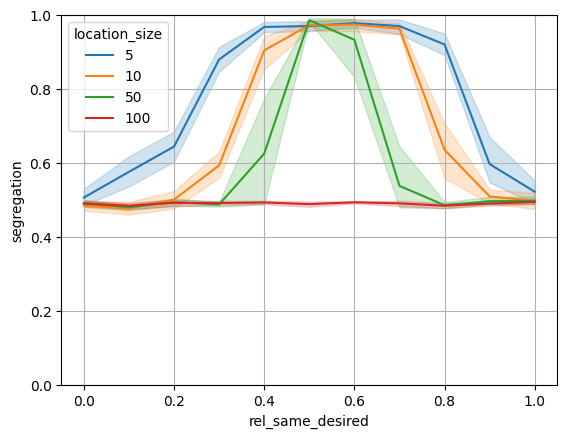

In [7]:
df.location_size = df.location_size.apply(lambda x: str(x))

sns.lineplot(
    data=df,
    x='rel_same_desired',
    y='segregation',
    hue="location_size",
)
plt.grid()
plt.ylim(0,1)